In [1]:
import pprint
import tempfile
import tensorflow as tf
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["TVM_LIBRARY_PATH"]="/workspace/build_tvm"

from arachne.device import get_target
from arachne.pipeline import Pipeline
from arachne.compile import compile_for_keras
from arachne.pipeline.runner import make_params_for_target, run_pipeline
from arachne.pipeline.stage.registry import get_stage
from arachne.runtime import TVMRuntimeModule, runner_init
from arachne.target import TVMCTarget

In [2]:
# Load Keras MobileNetV1 pretrained model
mobilenet = tf.keras.applications.mobilenet.MobileNet()
mobilenet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

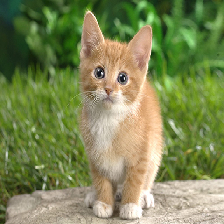

In [3]:
# Load image
image_pil = tf.keras.preprocessing.image.load_img(
    'image/cat.jpg', target_size=(224, 224)
)
image_pil.show()

In [4]:
# Preprocess
image_np = tf.keras.preprocessing.image.img_to_array(image_pil)
preprocess_input = tf.keras.applications.mobilenet.preprocess_input(image_np)
preprocess_input = preprocess_input[tf.newaxis, ...]

In [5]:
# Inference by Keras
preds_keras = mobilenet.predict(preprocess_input)
preds_keras = tf.keras.applications.mobilenet.decode_predictions(preds_keras)
pprint.pprint(preds_keras)

[[('n02123159', 'tiger_cat', 0.3346962),
  ('n02124075', 'Egyptian_cat', 0.28513753),
  ('n02123045', 'tabby', 0.15471701),
  ('n02119789', 'kit_fox', 0.03160481),
  ('n02127052', 'lynx', 0.030886412)]]


In [6]:
# Set compile parameters
tmp_dir = tempfile.mkdtemp()

target = "jetson-xavier-nx"
# target = "host,trt,cpu"
compile_pipeline:Pipeline = [("tvm_compiler", {})]

# Compile for host
pkgs = compile_for_keras(mobilenet, target, compile_pipeline, tmp_dir)
pkg = pkgs[-1]

[INFO /workspace/python/arachne/pipeline/runner.py:47] Running tvm_compiler stage...


In [7]:
# Init the runtime module on the edge device via RPC
RPC_TRACKER = "0.0.0.0:8889"
RPC_KEY = "jetson-xavier-nx"
mod: TVMRuntimeModule = runner_init(pkg, rpc_tracker=RPC_TRACKER, rpc_key=RPC_KEY)
# mod: TVMRuntimeModule = runner_init(pkg)

[INFO /workspace/python/arachne/runtime/session.py:20] RPC tracker hostname: 0.0.0.0
[INFO /workspace/python/arachne/runtime/session.py:21] RPC tracker port: 8889


In [8]:
# Inference on the edge device
mod.set_input(0, preprocess_input)
mod.run()
output_info = mod.get_output_details()
output = mod.get_outputs(output_info).get_by_index(0)[1]
preds = tf.keras.applications.mobilenet.decode_predictions(output)
pprint.pprint(preds)

[[('n02123159', 'tiger_cat', 0.33408725),
  ('n02124075', 'Egyptian_cat', 0.2835362),
  ('n02123045', 'tabby', 0.15658353),
  ('n02119789', 'kit_fox', 0.031811878),
  ('n02127052', 'lynx', 0.030833129)]]


In [9]:
# Benchmark performance
r = mod.benchmark(repeat=10)
print("Benchmark result[ms]: ", r)

Benchmark result[ms]:  {'mean': 2.4391305999999995, 'std': 0.04095941181267139, 'max': 2.527998, 'min': 2.392285}
